<a href="https://colab.research.google.com/github/NinaAbeyratne/domain-shift-medical-segmentation/blob/main/Preprocessing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pickle
from scipy.ndimage import gaussian_filter
from skimage import draw
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Base directory in Google Drive
BASE_DIR = Path('/content/drive/MyDrive/MV CW/V2')

# Create directories
(BASE_DIR / 'data/synthetic').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'data/real').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'data/processed').mkdir(parents=True, exist_ok=True)

print(f"Environment setup complete at: {BASE_DIR}")

Environment setup complete at: /content/drive/MyDrive/MV CW/V2


# Synthetic Data Generation

In [5]:
def generate_synthetic_lung_mask(img_size=256, seed=None):
    if seed is not None:
        np.random.seed(seed)

    mask = np.zeros((img_size, img_size), dtype=np.uint8)

    center_y = img_size // 2 + np.random.randint(-15, 15)
    radius_y = img_size // 4 + np.random.randint(-10, 10)

    # LEFT LUNG (independent)
    radius_x_left = img_size // 6 + np.random.randint(-5, 5)
    center_x_left = img_size // 2 - img_size // 5 + np.random.randint(-5, 5)
    left_lung = np.zeros_like(mask)
    rr, cc = draw.ellipse(center_y, center_x_left, radius_y, radius_x_left, shape=mask.shape)
    left_lung[rr, cc] = 1
    left_lung = taper_single_lung(left_lung, top_strength=0.4, bottom_strength=0.2)
    left_lung = add_heart(left_lung, radius_fraction=0.15)

    # RIGHT LUNG (independent)
    radius_x_right = img_size // 6 + np.random.randint(-5, 5)
    center_x_right = img_size // 2 + img_size // 5 + np.random.randint(-5, 5)
    right_lung = np.zeros_like(mask)
    rr, cc = draw.ellipse(center_y, center_x_right, radius_y, radius_x_right, shape=mask.shape)
    right_lung[rr, cc] = 1
    right_lung = taper_single_lung(right_lung, top_strength=0.35, bottom_strength=0.15)

    # Combine lungs
    mask = left_lung | right_lung

    # Smooth edges lightly
    mask = gaussian_filter(mask.astype(float), sigma=0.8)
    mask = (mask > 0.5).astype(np.uint8)

    # Add heart last (after smoothing)
    mask = add_heart(mask, radius_fraction=0.1)

    # Add diaphragm curvature
    mask = add_diaphragm_curvature(mask, strength=0.07)

    return mask


In [6]:
def taper_single_lung(mask, top_strength=0.3, bottom_strength=0.1):
    """
    Apply vertical tapering to a single lung region.

    - top_strength: fraction of narrowing at the apex
    - bottom_strength: fraction of widening at the base
    """
    h, w = mask.shape
    tapered = np.zeros_like(mask)

    for y in range(h):
        # Non-linear scaling: more narrowing at top, slight widening at bottom
        factor = 1 - top_strength * (1 - y/h)**2 + bottom_strength * (y/h)**2

        cols = np.where(mask[y] == 1)[0]
        if len(cols) == 0:
            continue
        center = int(cols.mean())
        half_width = int((cols[-1] - cols[0]) * factor / 2)

        left = max(0, center - half_width)
        right = min(w, center + half_width)

        tapered[y, left:right] = 1

    return tapered


In [7]:
def add_heart_indentation(left_lung, strength=0.10):
    """
    Create a concave indentation on the medial side of the left lung
    to simulate heart impression.
    """
    h, w = left_lung.shape
    modified = left_lung.copy()

    for y in range(int(0.35*h), int(0.65*h)):
        cols = np.where(modified[y] == 1)[0]
        if len(cols) == 0:
            continue

        indent = int(strength * (cols[-1] - cols[0]))
        modified[y, cols[-indent:]] = 0  # medial side

    return modified

In [8]:
def add_heart(mask, radius_fraction=0.05):
    """
    Add a simple circular heart region.
    - radius_fraction: fraction of image size (smaller heart)
    - Placed on the correct side for a frontal X-ray (patient's left = image right)
    """
    h, w = mask.shape
    radius = int(h * radius_fraction)

    # Heart on right side of image (patient's left)
    center_x = w//2 + w//8
    center_y = int(h * 0.55)  # slightly lower than mid-lung

    rr, cc = draw.disk((center_y, center_x), radius, shape=mask.shape)
    mask[rr, cc] = 0  # heart removes lung area

    return mask


In [9]:
def add_diaphragm_curvature(mask, strength=0.08):
    """
    Curve the lung base upward to mimic diaphragm shape.
    """
    h, w = mask.shape
    curved = mask.copy()

    for x in range(w):
        column = np.where(curved[:, x] == 1)[0]
        if len(column) == 0:
            continue

        shift = int(strength * h * np.sin(np.pi * x / w))
        curved[column[-shift:], x] = 0

    return curved


In [10]:
mask_final = generate_synthetic_lung_mask(seed=45)
print(mask_final.shape)

(256, 256)


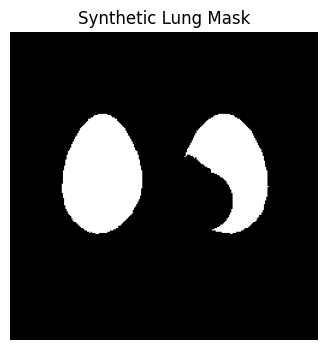

In [11]:
plt.figure(figsize=(4,4))
plt.imshow(mask_final, cmap="gray")
plt.title("Synthetic Lung Mask")
plt.axis("off")
plt.show()

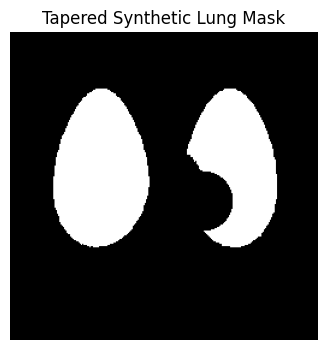

In [12]:
mask = generate_synthetic_lung_mask(seed=42)

plt.figure(figsize=(4,4))
plt.imshow(mask, cmap="gray")
plt.title("Tapered Synthetic Lung Mask")
plt.axis("off")
plt.show()

this shows the synthetic lung mask generated and the lungs in white colour.

In [13]:
def generate_synthetic_xray(mask, img_size=256):
    """
    Generate a synthetic chest X-ray from a lung mask.

    Simulates:
    - Lungs: darker (more radiolucent, air-filled)
    - Background: lighter (bone, soft tissue)
    - Minimal noise and artifacts

    Args:
        mask: Binary lung segmentation mask
        img_size: Image dimensions

    Returns:
        image: Synthetic grayscale X-ray image
    """
    # Create base image with uniform background
    image = np.ones((img_size, img_size)) * 0.7  # Background intensity)

    # Lung regions are darker (air is radiolucent)
    image[mask == 1] = 0.25

    # Add subtle gradient to simulate varying Tissue Density
    y_grad = np.linspace(0.95, 1.05, img_size)
    x_grad = np.linspace(0.98, 1.02, img_size)
    gradient = np.outer(y_grad, x_grad)
    image = image * gradient

    # Add minimal Gaussian noise (synthetic data is cleaner)
    noise = np.random.normal(0, 0.02, image.shape)
    image = image + noise

    # Apply slight blur (simulate imaging process)
    image = gaussian_filter(image, sigma=0.8)

    # Normalize to [0, 1]
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)

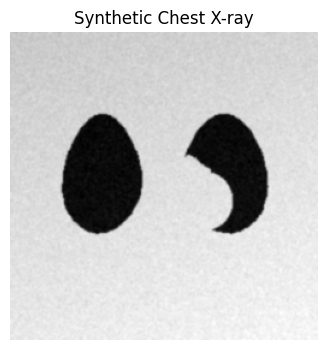

In [14]:
synthetic_xray = generate_synthetic_xray(mask_final)

plt.figure(figsize=(4,4))
plt.imshow(synthetic_xray, cmap="gray")
plt.title("Synthetic Chest X-ray")
plt.axis("off")
plt.show()

this shows the synthetic chest X-ray where the air filled lungs are shown in black because the X-rays are passed through the lungs easily where white colour areas represents dense tissues/bones where X-rays are absorbed.

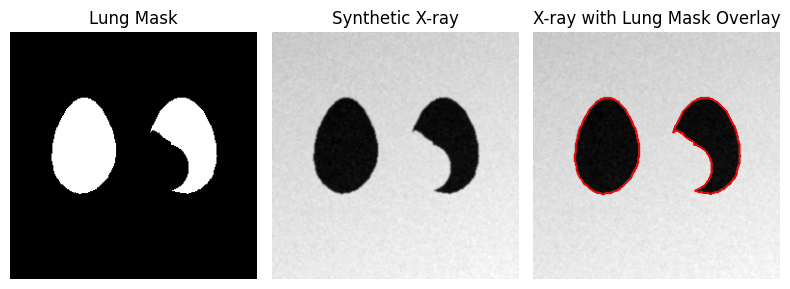

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(8,4))

axs[0].imshow(mask_final, cmap="gray")
axs[0].set_title("Lung Mask")
axs[0].axis("off")

axs[1].imshow(synthetic_xray, cmap="gray")
axs[1].set_title("Synthetic X-ray")
axs[1].axis("off")

axs[2].imshow(synthetic_xray, cmap="gray")
axs[2].contour(mask_final, colors='red', linewidths=0.5)
axs[2].set_title("X-ray with Lung Mask Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

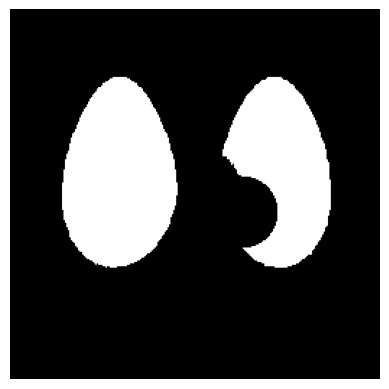

In [16]:
mask = generate_synthetic_lung_mask(seed=42)
plt.imshow(mask, cmap="gray")
plt.axis("off")

Lungs in black and the mask overlay in red which when overlapping shows as a small red outline.

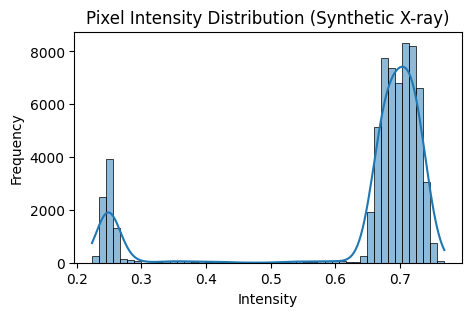

In [17]:
plt.figure(figsize=(5,3))
sns.histplot(synthetic_xray.flatten(), bins=50, kde=True)
plt.title("Pixel Intensity Distribution (Synthetic X-ray)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

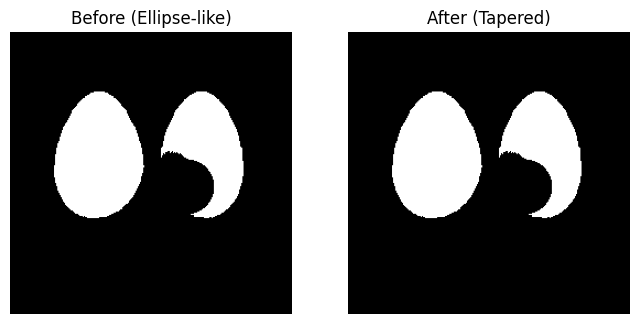

In [18]:

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].imshow(generate_synthetic_lung_mask(seed=1), cmap="gray")
ax[0].set_title("Before (Ellipse-like)")

ax[1].imshow(generate_synthetic_lung_mask(seed=1), cmap="gray")
ax[1].set_title("After (Tapered)")

for a in ax: a.axis("off")
plt.show()

The synthetic X-ray exhibits a realistic bimodal intensity distribution corresponding to lung and non-lung regions

In [19]:
# Generate synthetic dataset
print("\n" + "="*70)
print("GENERATING SYNTHETIC DATASET")
print("="*70)

n_synthetic_train = 800
n_synthetic_val = 100

synthetic_train_images = []
synthetic_train_masks = []
synthetic_val_images = []
synthetic_val_masks = []

print(f"Creating {n_synthetic_train} training samples...")
for i in tqdm(range(n_synthetic_train)):
    mask = generate_synthetic_lung_mask(seed=i)
    image = generate_synthetic_xray(mask)
    synthetic_train_images.append(image)
    synthetic_train_masks.append(mask)

print(f"Creating {n_synthetic_val} validation samples...")
for i in tqdm(range(n_synthetic_val)):
    mask = generate_synthetic_lung_mask(seed=i + 10000)
    image = generate_synthetic_xray(mask)
    synthetic_val_images.append(image)
    synthetic_val_masks.append(mask)

synthetic_train_images = np.array(synthetic_train_images)
synthetic_train_masks = np.array(synthetic_train_masks)
synthetic_val_images = np.array(synthetic_val_images)
synthetic_val_masks = np.array(synthetic_val_masks)

# Add channel dimension at axis=1 (PyTorch format: N,C,H,W)
synthetic_train_images = synthetic_train_images[:, np.newaxis, :, :]
synthetic_val_images   = synthetic_val_images[:, np.newaxis, :, :]

synthetic_train_masks  = synthetic_train_masks[:, np.newaxis, :, :]
synthetic_val_masks    = synthetic_val_masks[:, np.newaxis, :, :]

print(f"\nSynthetic training set: {synthetic_train_images.shape}")
print(f"Synthetic validation set: {synthetic_val_images.shape}")


GENERATING SYNTHETIC DATASET
Creating 800 training samples...


100%|██████████| 800/800 [00:13<00:00, 57.96it/s]


Creating 100 validation samples...


100%|██████████| 100/100 [00:01<00:00, 63.54it/s]



Synthetic training set: (800, 1, 256, 256)
Synthetic validation set: (100, 1, 256, 256)


All images and masks were reshaped to include an explicit channel dimension, conforming to the PyTorch tensor format (N, C, H, W) required for the CNN

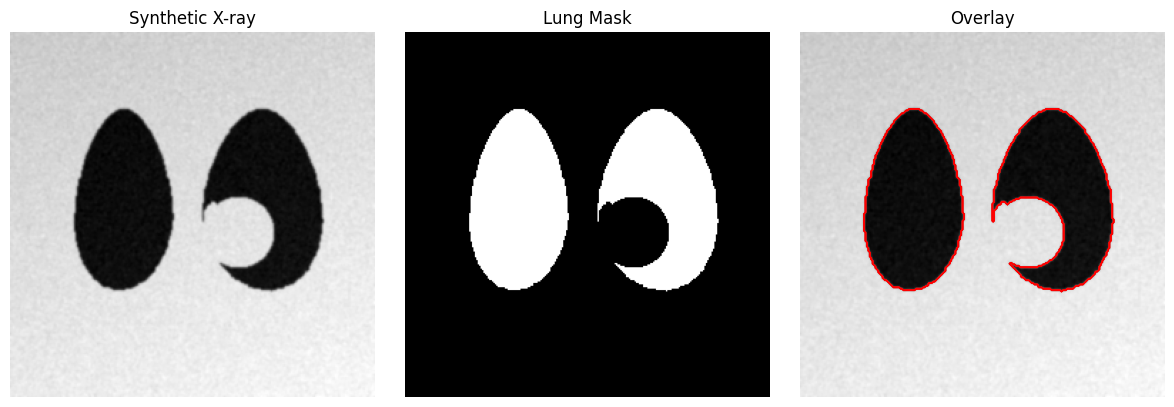

In [20]:
import random

idx = random.randint(0, n_synthetic_train - 1)

fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(synthetic_train_images[idx, 0], cmap="gray")
axs[0].set_title("Synthetic X-ray")
axs[0].axis("off")

axs[1].imshow(synthetic_train_masks[idx, 0], cmap="gray")
axs[1].set_title("Lung Mask")
axs[1].axis("off")

axs[2].imshow(synthetic_train_images[idx, 0], cmap="gray")
axs[2].contour(synthetic_train_masks[idx, 0], colors='red', linewidths=0.5)
axs[2].set_title("Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()

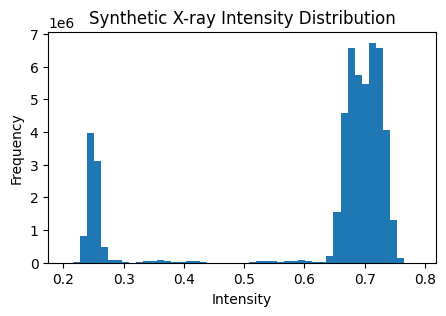

In [21]:
plt.figure(figsize=(5,3))
plt.hist(synthetic_train_images.flatten(), bins=50)
plt.title("Synthetic X-ray Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Real Data Generation (Simulated From Synthetic)

In [22]:
def generate_real_xray(mask, img_size=256, seed=None):
    """
    Generate a realistic chest X-ray with imaging artifacts and complexity.

    Differences from synthetic:
    - Higher noise levels
    - Contrast variations
    - Texture and structural artifacts
    - Less uniform intensities

    Args:
        mask: Binary lung mask (used as anatomical template)
        img_size: Image dimensions
        seed: Random seed

    Returns:
        image: Simulated real X-ray image
    """
    if seed is not None:
        np.random.seed(seed)

    # Start with base synthetic image
    image = np.ones((img_size, img_size)) * np.random.uniform(0.65, 0.75)

    # Lung regions with more intensity variation
    lung_intensity = np.random.uniform(0.2, 0.35)
    image[mask == 1] = lung_intensity

    # Add anatomical texture (simulates vessels, ribs)
    texture = np.random.randn(img_size, img_size) * 0.05
    texture = gaussian_filter(texture, sigma=2.0)
    image = image + texture

    # Add strong Gaussian noise (real images are noisier)
    noise = np.random.normal(0, 0.05, image.shape)
    image = image + noise

    # Add intensity inhomogeneity (bias field)
    y, x = np.ogrid[:img_size, :img_size]
    bias_field = 1 + 0.15 * np.sin(y / img_size * np.pi) * np.cos(x / img_size * np.pi)
    image = image * bias_field

    # Random contrast adjustment
    contrast_factor = np.random.uniform(0.85, 1.15)
    image = (image - 0.5) * contrast_factor + 0.5

    # Apply stronger blur (simulates motion/patient factors)
    blur_sigma = np.random.uniform(1.0, 2.0)
    image = gaussian_filter(image, sigma=blur_sigma)

    # Normalize
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)

In [23]:
def add_anatomical_complexity_to_mask(mask, seed=None):
    """
    Add realistic irregularities to lung mask boundaries.

    Real lung boundaries are:
    - Not perfectly smooth
    - May have small indentations (vessels, fissures)
    - Can have pathological changes

    Args:
        mask: Binary mask
        seed: Random seed

    Returns:
        mask: Modified mask with irregular boundaries
    """
    if seed is not None:
        np.random.seed(seed)

    # Add small random erosions/dilations
    kernel_size = np.random.choice([3, 5])
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    if np.random.rand() > 0.5:
        mask = cv2.erode(mask, kernel, iterations=1)
    else:
        mask = cv2.dilate(mask, kernel, iterations=1)

    # Add slight noise to boundaries
    boundary_noise = np.random.randn(*mask.shape) * 0.1
    boundary_noise = gaussian_filter(boundary_noise, sigma=2.0)

    mask_float = mask.astype(float) + boundary_noise
    mask = (mask_float > 0.5).astype(np.uint8)

    return mask

In [24]:
# Generate real dataset (simulated)
print("\n" + "="*70)
print("GENERATING REAL DATASET (SIMULATED)")
print("="*70)

n_real_test = 150

real_test_images = []
real_test_masks = []

print(f"Creating {n_real_test} real test samples...")
for i in tqdm(range(n_real_test)):
    # Generate base mask
    base_mask = generate_synthetic_lung_mask(seed=i + 20000)
    # Add anatomical complexity
    mask = add_anatomical_complexity_to_mask(base_mask, seed=i + 20000)
    # Generate realistic image
    image = generate_real_xray(mask, seed=i + 20000)

    real_test_images.append(image)
    real_test_masks.append(mask)

real_test_images = np.array(real_test_images)
real_test_masks = np.array(real_test_masks)

print(f"\nReal test set: {real_test_images.shape}")


GENERATING REAL DATASET (SIMULATED)
Creating 150 real test samples...


100%|██████████| 150/150 [00:03<00:00, 38.09it/s]


Real test set: (150, 256, 256)


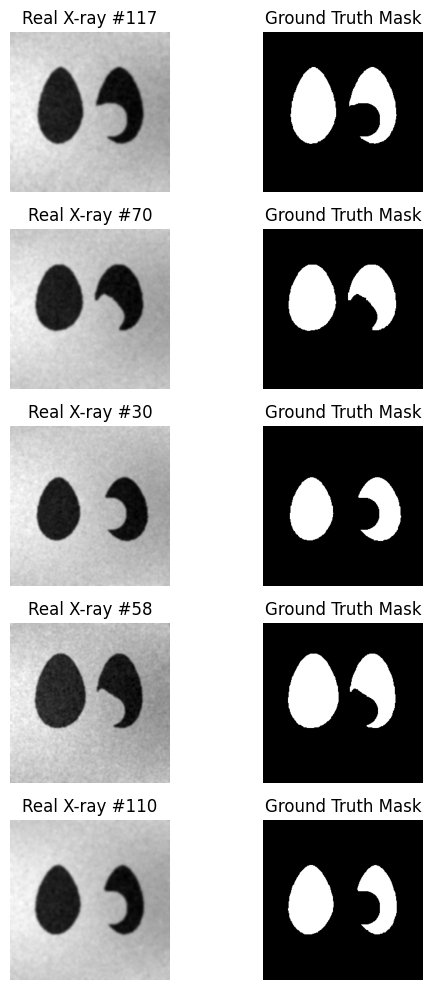

In [25]:
num_samples = 5
indices = random.sample(range(len(real_test_images)), num_samples)

fig, axs = plt.subplots(num_samples, 2, figsize=(6, 2*num_samples))

for i, idx in enumerate(indices):
    axs[i, 0].imshow(real_test_images[idx], cmap='gray')
    axs[i, 0].set_title(f"Real X-ray #{idx}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(real_test_masks[idx], cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

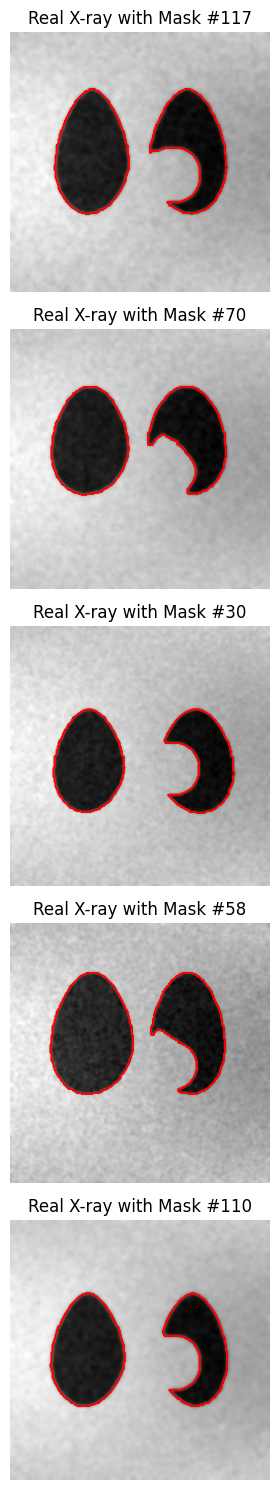

In [26]:
fig, axs = plt.subplots(num_samples, 1, figsize=(4, 3*num_samples))

for i, idx in enumerate(indices):
    axs[i].imshow(real_test_images[idx], cmap='gray')
    axs[i].contour(real_test_masks[idx], colors='red', linewidths=0.6)
    axs[i].set_title(f"Real X-ray with Mask #{idx}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

In [27]:
def normalize_images(images):
    """
    Normalize images to zero mean and unit variance.

    Args:
        images: Array of images [N, H, W]

    Returns:
        normalized: Normalized images
        mean: Dataset mean (for potential denormalization)
        std: Dataset std
    """
    mean = images.mean()
    std = images.std()
    normalized = (images - mean) / (std + 1e-8)
    return normalized, mean, std

# Normalize datasets separately (preserves domain characteristics)
print("\n" + "="*70)
print("PREPROCESSING DATASETS")
print("="*70)

synthetic_train_norm, syn_mean, syn_std = normalize_images(synthetic_train_images)
synthetic_val_norm, _, _ = normalize_images(synthetic_val_images)
real_test_norm, real_mean, real_std = normalize_images(real_test_images)

print(f"Synthetic training - Mean: {syn_mean:.3f}, Std: {syn_std:.3f}")
print(f"Real test - Mean: {real_mean:.3f}, Std: {real_std:.3f}")



PREPROCESSING DATASETS
Synthetic training - Mean: 0.622, Std: 0.170
Real test - Mean: 0.627, Std: 0.165


Normalization is applied after image synthesis to standardize intensity distributions for stable neural network training

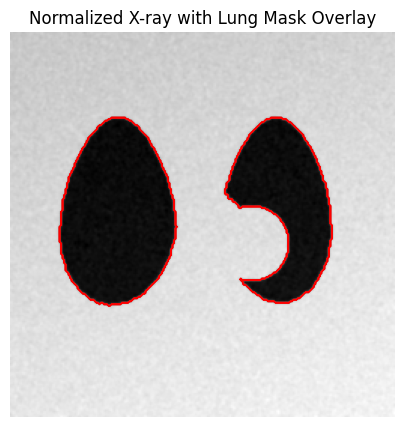

In [31]:
plt.figure(figsize=(5,5))
plt.imshow(synthetic_train_norm[0].squeeze(), cmap="gray")
plt.contour(synthetic_train_masks[0].squeeze(), colors="red", linewidths=0.5)
plt.title("Normalized X-ray with Lung Mask Overlay")
plt.axis("off")
plt.show()

# Domain Comparison

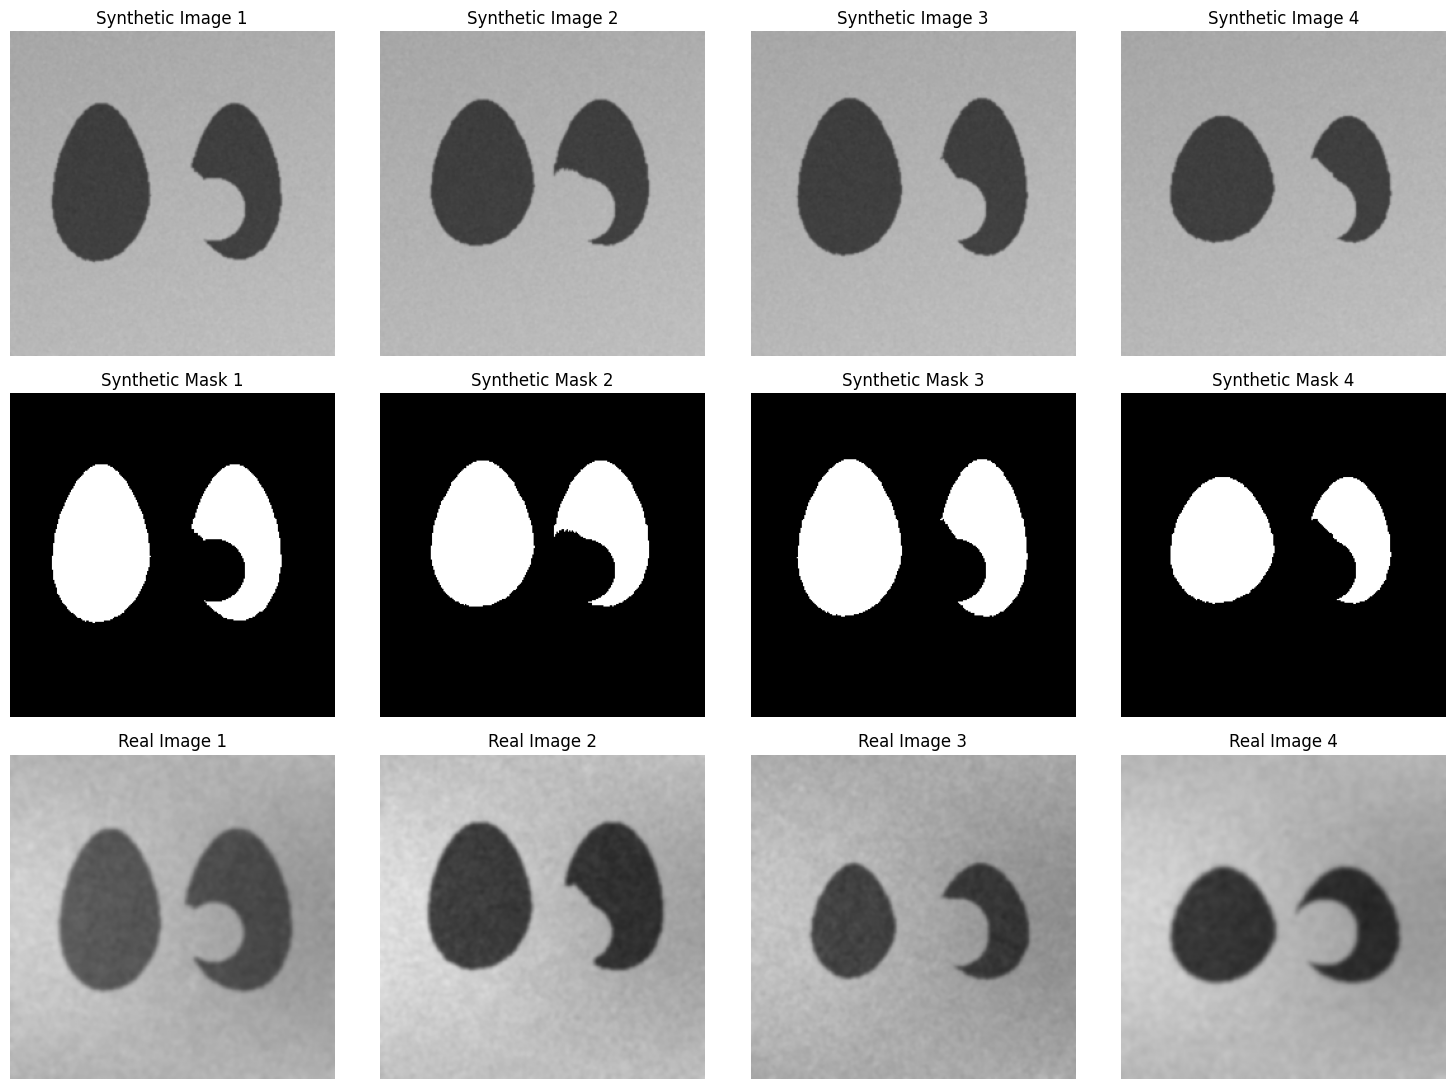


Visual comparison saved.


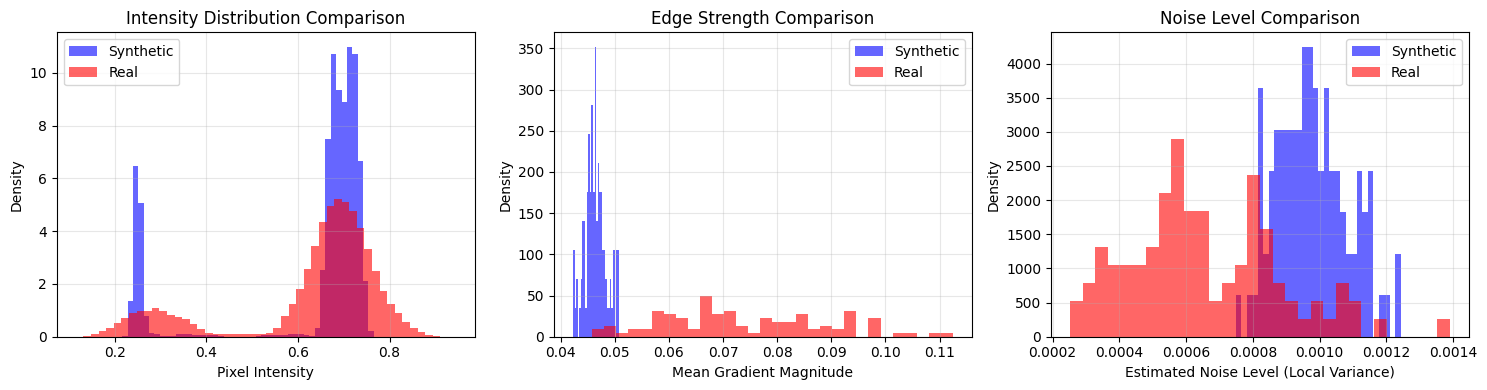

Statistical comparison saved.


In [47]:
# Visualize samples
fig, axes = plt.subplots(3, 4, figsize=(15, 11))

# Synthetic examples
for i in range(4):
    axes[0, i].imshow(synthetic_train_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Synthetic Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(synthetic_train_masks[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Synthetic Mask {i+1}')
    axes[1, i].axis('off')

# Real examples
for i in range(4):
    axes[2, i].imshow(real_test_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Real Image {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(BASE_DIR / 'data/processed/domain_comparison_visual.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\nVisual comparison saved.")

# Statistical comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Intensity distributions
axes[0].hist(synthetic_train_images.flatten(), bins=50, alpha=0.6,
             label='Synthetic', density=True, color='blue')
axes[0].hist(real_test_images.flatten(), bins=50, alpha=0.6,
             label='Real', density=True, color='red')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Density')
axes[0].set_title('Intensity Distribution Comparison')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Compute gradient magnitudes (edge strength)
syn_gradients = []
real_gradients = []

for img in synthetic_train_images[:100]:
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    syn_gradients.append(grad_mag.mean())

for img in real_test_images[:100]:
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    real_gradients.append(grad_mag.mean())

axes[1].hist(syn_gradients, bins=30, alpha=0.6, label='Synthetic',
             density=True, color='blue')
axes[1].hist(real_gradients, bins=30, alpha=0.6, label='Real',
             density=True, color='red')
axes[1].set_xlabel('Mean Gradient Magnitude')
axes[1].set_ylabel('Density')
axes[1].set_title('Edge Strength Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Noise estimation (local variance)
def estimate_noise(images, patch_size=5):
    noise_levels = []
    for img in images[:100]:

        # Handle (1, H, W) or (H, W)
        if img.ndim == 3:
            img = img.squeeze(0)

        h, w = img.shape
        local_vars = []

        for i in range(0, h - patch_size, patch_size):
            for j in range(0, w - patch_size, patch_size):
                patch = img[i:i+patch_size, j:j+patch_size]
                local_vars.append(np.var(patch))

        noise_levels.append(np.mean(local_vars))

    return noise_levels

syn_noise = estimate_noise(synthetic_train_images)
real_noise = estimate_noise(real_test_images)

axes[2].hist(syn_noise, bins=30, alpha=0.6, label='Synthetic',
             density=True, color='blue')
axes[2].hist(real_noise, bins=30, alpha=0.6, label='Real',
             density=True, color='red')
axes[2].set_xlabel('Estimated Noise Level (Local Variance)')
axes[2].set_ylabel('Density')
axes[2].set_title('Noise Level Comparison')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'data/processed/domain_comparison_stats.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("Statistical comparison saved.")

In [45]:
print("Synthetic noise mean:", np.mean(syn_noise))
print("Real noise mean:", np.mean(real_noise))

Synthetic noise mean: 0.0009782368
Real noise mean: 0.0006542302


# Save Preproccessed Data

In [56]:
import os

print("\n" + "="*70)
print("SAVING PROCESSED DATASETS")
print("="*70)

os.makedirs('data/processed', exist_ok=True)

# Save as numpy arrays
np.save(BASE_DIR / 'data/processed/synthetic_train_images.npy', synthetic_train_norm)
np.save(BASE_DIR / 'data/processed/synthetic_train_masks.npy', synthetic_train_masks)
np.save(BASE_DIR / 'data/processed/synthetic_val_images.npy', synthetic_val_norm)
np.save(BASE_DIR / 'data/processed/synthetic_val_masks.npy', synthetic_val_masks)
np.save(BASE_DIR / 'data/processed/real_test_images.npy', real_test_norm)
np.save(BASE_DIR / 'data/processed/real_test_masks.npy', real_test_masks)

# Save statistics
stats = {
    'synthetic_mean': syn_mean,
    'synthetic_std': syn_std,
    'real_mean': real_mean,
    'real_std': real_std
}

# Save normalization statistics
with open(BASE_DIR / 'data/processed/normalization_stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

print("\nData saved to data/processed/")
print("\nDataset Summary:")
print(f"  Synthetic Training: {synthetic_train_norm.shape[0]} images")
print(f"  Synthetic Validation: {synthetic_val_norm.shape[0]} images")
print(f"  Real Test: {real_test_norm.shape[0]} images")


SAVING PROCESSED DATASETS

Data saved to data/processed/

Dataset Summary:
  Synthetic Training: 800 images
  Synthetic Validation: 100 images
  Real Test: 150 images


# Montgomery Data - For Validation

In [58]:
import os
from skimage.io import imread
from skimage.transform import resize

montgomery_path = (BASE_DIR / "data/montgomery/")
montgomery_img_files = sorted([f for f in os.listdir(os.path.join(montgomery_path, "images")) if f.endswith(".png")])
montgomery_mask_files = sorted([f for f in os.listdir(os.path.join(montgomery_path, "masks")) if f.endswith(".png")])

montgomery_images = []
montgomery_masks = []

img_size = 256  # same as synthetic and real

for img_file, mask_file in zip(montgomery_img_files, montgomery_mask_files):
    img = imread(os.path.join(montgomery_path, "images", img_file), as_gray=True)
    mask = imread(os.path.join(montgomery_path, "masks", mask_file), as_gray=True)

    # Resize to match your model input
    img = resize(img, (img_size, img_size), anti_aliasing=True)
    mask = resize(mask, (img_size, img_size), anti_aliasing=False)

    montgomery_images.append(img)
    montgomery_masks.append(mask > 0.5)  # binarize mask

montgomery_images = np.array(montgomery_images)
montgomery_masks = np.array(montgomery_masks)
print("Montgomery dataset loaded:", montgomery_images.shape)


Montgomery dataset loaded: (20, 256, 256)


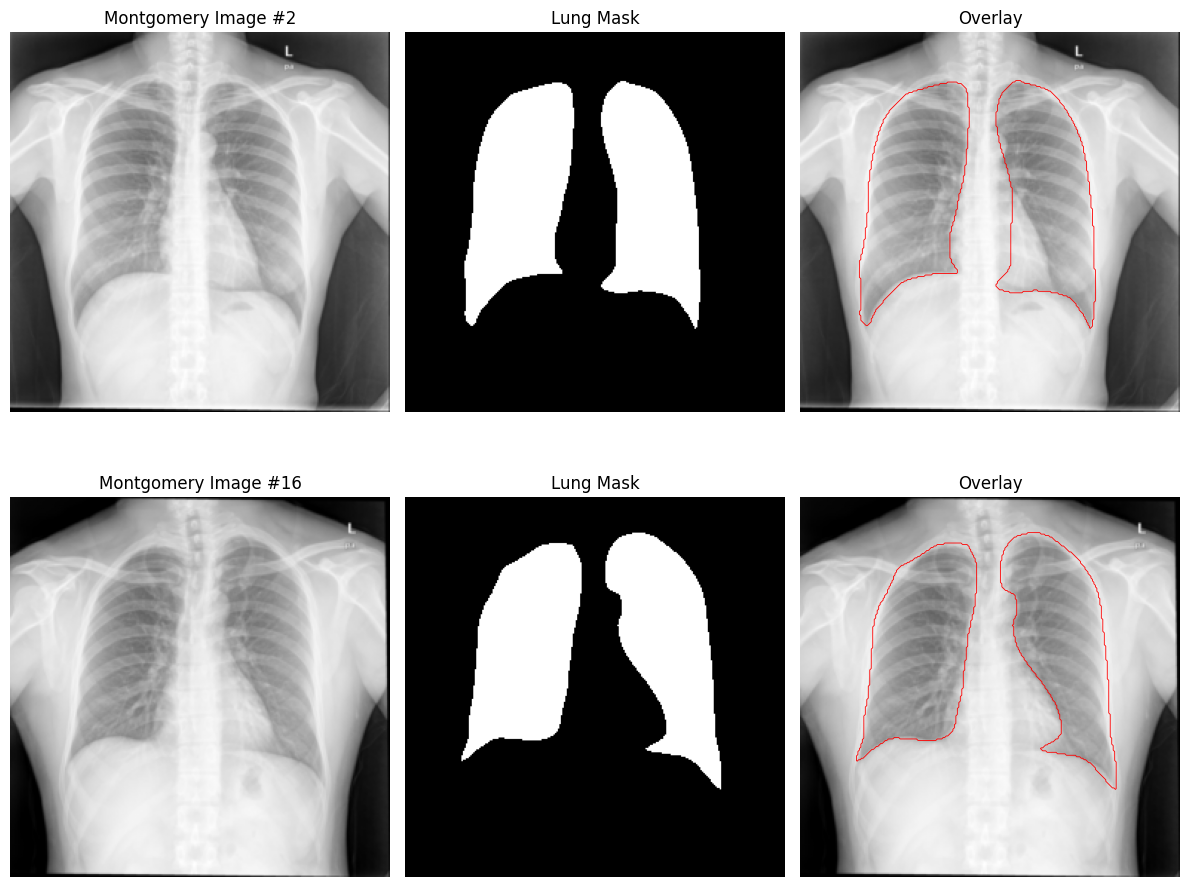

In [59]:
import random
import matplotlib.pyplot as plt

# Number of samples to visualize
num_samples = 2
indices = random.sample(range(len(montgomery_images)), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 5*num_samples))

for i, idx in enumerate(indices):
    # Original image
    axes[i, 0].imshow(montgomery_images[idx], cmap='gray')
    axes[i, 0].set_title(f"Montgomery Image #{idx}")
    axes[i, 0].axis('off')

    # Ground truth mask
    axes[i, 1].imshow(montgomery_masks[idx], cmap='gray')
    axes[i, 1].set_title("Lung Mask")
    axes[i, 1].axis('off')

    # Overlay mask on image
    axes[i, 2].imshow(montgomery_images[idx], cmap='gray')
    axes[i, 2].contour(montgomery_masks[idx], colors='red', linewidths=0.6)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [60]:
def normalize_images(images):
    mean = images.mean()
    std = images.std()
    normalized = (images - mean) / (std + 1e-8)
    return normalized, mean, std

montgomery_norm, mont_mean, mont_std = normalize_images(montgomery_images)
print(f"Montgomery images - mean: {mont_mean:.3f}, std: {mont_std:.3f}")

Montgomery images - mean: 0.648, std: 0.252


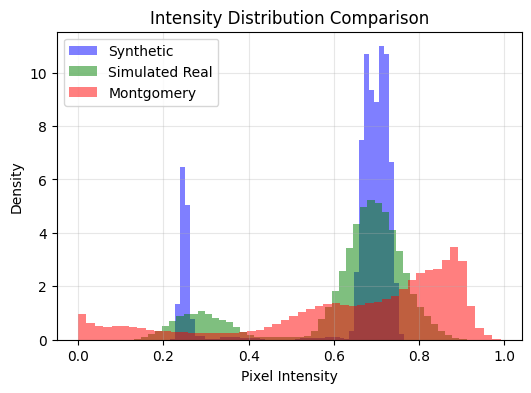

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(synthetic_train_images.flatten(), bins=50, alpha=0.5, label="Synthetic", density=True, color="blue")
plt.hist(real_test_images.flatten(), bins=50, alpha=0.5, label="Simulated Real", density=True, color="green")
plt.hist(montgomery_images.flatten(), bins=50, alpha=0.5, label="Montgomery", density=True, color="red")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.title("Intensity Distribution Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [62]:
print("Synthetic - mean/std:", synthetic_train_images.mean(), synthetic_train_images.std())
print("Simulated Real - mean/std:", real_test_images.mean(), real_test_images.std())
print("Montgomery - mean/std:", montgomery_images.mean(), montgomery_images.std())

Synthetic - mean/std: 0.6224623 0.16959743
Simulated Real - mean/std: 0.6269182 0.16547549
Montgomery - mean/std: 0.6479034820259333 0.25160031097824187
